# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

25088


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook

## Codebook

**Codebook** example from [codebook_link](../0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


## Refgen for gene dist matrix


**Refgen** example from [Refgen_link](../0_locus_annotation/resources/refgen_df_for_jie.csv)

In [9]:
codebook_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
df_refgen_savename = os.path.join(codebook_folder,'refgen_df_for_jie.csv')
df_refgen=pd.read_csv(df_refgen_savename,index_col=0)
df_refgen['chr'] = df_refgen['chr'].apply(lambda x: 'chr'+x)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5


In [10]:
chrom_number = []
for i, row in df_refgen.iterrows():
    if ('X' in row.chr):
        chrom_number.append(20)
    elif ('Y' in row.chr):
        chrom_number.append(21)
    else:
        chrom_number.append(int(row['chr'].split('chr')[-1]))
df_refgen['chrom_number'] = chrom_number
df_refgen.sort_values(['chrom_number','hyb'], inplace=True, ignore_index=True)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id,chrom_number
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2,1
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3,1
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4,1
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5,1


In [11]:
from scipy.spatial.distance import squareform, pdist
chr_gene_dist_matrices = {}
for chrom, df_chr in df_refgen.groupby('chr'):
    if 'Y' not in chrom:
        _df = df_chr.sort_values('hyb')
        _delta_values= np.zeros((len(_df),2))
        _delta_values[:,0] = _df.delta.values
        _gene_dist = squareform(pdist(_delta_values))
        chr_gene_dist_matrices[chrom] = _gene_dist

# 3. Load contact dict

Data can be generated from the notebook as:

[preprocess/2_dna_merfish/scripts/2_spot_pick/5_summarize_jie_to_dict_contact750](../../preprocess/2_dna_merfish/scripts/2_spot_pick/5_summarize_jie_to_dict_contact750.ipynb)

In [12]:
postanalysis_folder_CW = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0312'

class_2_contact_filename = os.path.join(postanalysis_folder_CW, 'class_2_contactDict_750.pkl')
print(class_2_contact_filename)
if os.path.exists(class_2_contact_filename):
    print("Loading contact")
    class_2_contactDict = np.load(class_2_contact_filename, allow_pickle=True)

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0312\class_2_contactDict_750.pkl
Loading contact


# 4. Load RNA/ATAC average by loci

In [13]:
import tqdm
sel_class_list = ['Gluta','GABA','Oligo','Astro','Endo','Micro']
ref_measure_dict_byGroup = {}

for _class in tqdm.tqdm(sel_class_list):
    _class_name = _class.replace(' ','_').replace('/','_')
    #print(_class_name)
    rna_atac_fname = os.path.join(output_analysis_folder,f'MajorType_{_class_name}_snATAC_snRNA_mean_by_loci.csv')
    if os.path.exists(rna_atac_fname):
        rna_atac_df = pd.read_csv(rna_atac_fname,index_col=1)
        ref_measure_dict_byGroup[_class] = rna_atac_df

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 64.70it/s]


In [14]:
rna_atac_df

,Unnamed: 0,mean_ATAC_2X_2000kb,mean_rna_2X_2000kb,mean_rna_2X_200kb
loci_name,,,,
chr1_3742742_3759944,0,1.391338,0.907407,0.462963
chr1_6245958_6258969,1,1.774731,1.925926,0.777778
chr1_8740008_8759916,2,2.144798,3.240741,0.000000
chr1_9627926_9637875,3,2.246028,2.759259,0.870370
chr1_9799472_9811359,4,2.271399,2.759259,0.703704
...,...,...,...,...
chrX_166247682_166259932,1977,2.507688,2.870370,0.666667
chrX_167157164_167167452,1978,2.485648,3.314815,1.870370
chrX_168746045_168757590,1979,2.334956,3.351852,0.574074


In [15]:
#rna_summary_df = pd.DataFrame(index = rna_df_dict['L2/3 IT'].index)
rna_summary_dict = {'rna':[],'atac':[],'loci':[],'celltype':[],'chr':[],}
for _group, _rna_df in ref_measure_dict_byGroup.items():
    #rna_summary_dict['rna'].extend(_rna_df['log10p_mean_rna'].tolist())
    #rna_summary_dict['rna'].extend(_rna_df['mean_rna'].tolist())
    rna_summary_dict['rna'].extend(_rna_df['mean_rna_2X_2000kb'].tolist())
    rna_summary_dict['atac'].extend(_rna_df['mean_ATAC_2X_2000kb'].tolist())
    rna_summary_dict['loci'].extend(_rna_df.index.tolist())
    rna_summary_dict['celltype'].extend([_group]*len(_rna_df))
    rna_summary_dict['chr'].extend([i.split('_')[0] for i in _rna_df.index.tolist()])

rna_summary_df = pd.DataFrame(rna_summary_dict)
rna_summary_df

,rna,atac,loci,celltype,chr
0,21.495658,3.801971,chr1_3742742_3759944,Gluta,chr1
1,11.692570,4.195687,chr1_6245958_6258969,Gluta,chr1
2,31.264248,5.626522,chr1_8740008_8759916,Gluta,chr1
3,38.439871,6.081351,chr1_9627926_9637875,Gluta,chr1
4,38.439871,6.252073,chr1_9799472_9811359,Gluta,chr1
...,...,...,...,...,...
11887,2.870370,2.507688,chrX_166247682_166259932,Micro,chrX
11888,3.314815,2.485648,chrX_167157164_167167452,Micro,chrX
11889,3.351852,2.334956,chrX_168746045_168757590,Micro,chrX
11890,1.407407,0.875705,chrX_169963295_170005197,Micro,chrX


In [16]:
#active_th = np.percentile(rna_summary_df['rna'], 50)
#assign_rna_by_absolute = True
h_p = 75
l_p = 25

for _col in ['rna', 'atac']:
    #if assign_rna_by_absolute: # assign using the percentile including all celltypes
    _method = 'abs'
    active_th_h = np.percentile(rna_summary_df[_col], h_p)
    active_th_l = np.percentile(rna_summary_df[_col], l_p)
    #print(active_th_h)
    #print(active_th_l)
    #rna_summary_df['activity'] = rna_summary_df['rna']>active_th
    rna_summary_df.loc[rna_summary_df[_col]>active_th_h,f'{_method}_{_col}_activity'] = 'high' 
    rna_summary_df.loc[rna_summary_df[_col]<=active_th_l,f'{_method}_{_col}_activity'] = 'low' 
    rna_summary_df.loc[(rna_summary_df[_col]<=active_th_h) & 
                       (rna_summary_df[_col]>active_th_l),f'{_method}_{_col}_activity'] = 'intermediate' 

    # assign individually by celltype
    _method = 'rel'
    for _class in tqdm.tqdm(sel_class_list):
        if _class in np.unique(rna_summary_df['celltype']):
            sel_rna_summary_df = rna_summary_df[rna_summary_df['celltype']==_class]
            active_th_h = np.percentile(sel_rna_summary_df[_col], h_p)
            active_th_l = np.percentile(sel_rna_summary_df[_col], l_p)
            #print(active_th_h)
            #print(active_th_l)
            #rna_summary_df['activity'] = rna_summary_df['rna']>active_th
            rna_summary_df.loc[(rna_summary_df['celltype']==_class)&
                               (rna_summary_df[_col]>active_th_h),f'{_method}_{_col}_activity'] = 'high' 
            rna_summary_df.loc[(rna_summary_df['celltype']==_class)&
                               (rna_summary_df[_col]<=active_th_l),f'{_method}_{_col}_activity'] = 'low' 
            rna_summary_df.loc[(rna_summary_df['celltype']==_class)&
                               (rna_summary_df[_col]<=active_th_h) & 
                               (rna_summary_df[_col]>active_th_l),f'{_method}_{_col}_activity'] = 'intermediate' 

rna_summary_df

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 85.96it/s]


,rna,atac,loci,celltype,chr,abs_rna_activity,rel_rna_activity,abs_atac_activity,rel_atac_activity
0,21.495658,3.801971,chr1_3742742_3759944,Gluta,chr1,high,intermediate,intermediate,low
1,11.692570,4.195687,chr1_6245958_6258969,Gluta,chr1,intermediate,intermediate,intermediate,low
2,31.264248,5.626522,chr1_8740008_8759916,Gluta,chr1,high,intermediate,high,intermediate
3,38.439871,6.081351,chr1_9627926_9637875,Gluta,chr1,high,high,high,intermediate
4,38.439871,6.252073,chr1_9799472_9811359,Gluta,chr1,high,high,high,intermediate
...,...,...,...,...,...,...,...,...,...
11887,2.870370,2.507688,chrX_166247682_166259932,Micro,chrX,low,intermediate,low,intermediate
11888,3.314815,2.485648,chrX_167157164_167167452,Micro,chrX,low,intermediate,low,intermediate
11889,3.351852,2.334956,chrX_168746045_168757590,Micro,chrX,low,intermediate,low,low
11890,1.407407,0.875705,chrX_169963295_170005197,Micro,chrX,low,low,low,low


# 5. Correlation map and PC values

Data below can be generated from notebook:

[3_ab_compartment_calculation_and_pca_analysis](3_ab_compartment_calculation_and_pca_analysis.ipynb)

In [17]:
import pickle
dict_pca_fname = os.path.join(output_analysis_folder,'majorType_pca_analysis_result.pkl')
dict_pca_result = pickle.load(open(dict_pca_fname,'rb'))

meta NOT subset; don't know how to subset; dropped


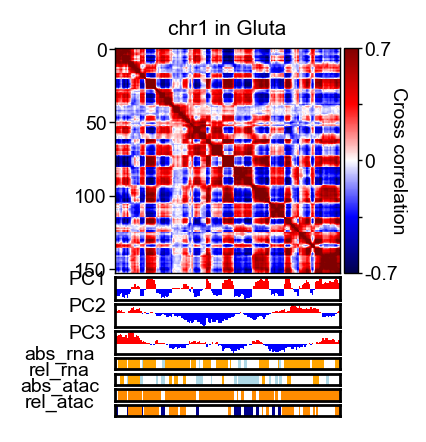

meta NOT subset; don't know how to subset; dropped


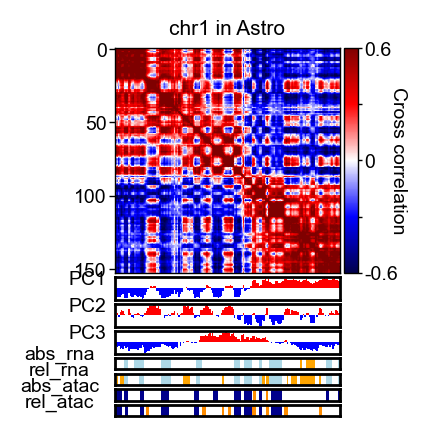

meta NOT subset; don't know how to subset; dropped


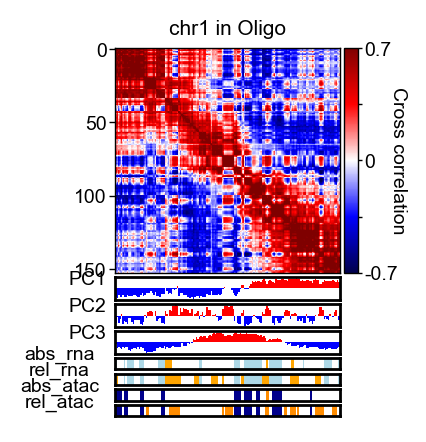

In [18]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

chrom = 'chr1'

#_font_size = 13
save_fig = True
rna_summary_df_chr = rna_summary_df[rna_summary_df['chr']==chrom]

for cell_type in ['Gluta','Astro','Oligo','GABA','Endo'][:3]:
#cell_type = 'Gluta'

    sel_pca_res = dict_pca_result[(cell_type, chrom)]



    correlation_map = sel_pca_res['correlation_map']
    figure_file = os.path.join(output_figure_folder,f'{cell_type}_{chrom}_ABcompartment.pdf')

    fig, ax1 = plt.subplots(figsize=(_page_width/2.3,_page_width/2.3), dpi=200)
    # create a color map
    current_cmap = cm.get_cmap('seismic').copy()
    current_cmap.set_bad(color=[0.5,0.5,0.5,1])
    upper_indices = np.triu_indices(len(correlation_map),k=1)
    all_corr = correlation_map[upper_indices]
    bound = round(np.max([abs(np.percentile(all_corr,95)), abs(np.percentile(all_corr,5))]),1)
    vmin = -bound
    vmax = bound
    _pf = ax1.imshow(correlation_map, 
                     cmap=current_cmap, vmin=vmin, vmax=vmax)

    ax1.xaxis.set_tick_params(which='both', labelbottom=True)
    ax1.yaxis.set_tick_params(which='both', labelleft=True)
    ax1.set_title(f"{chrom} in {cell_type}", fontsize=_font_size,pad=5)
    ax1.tick_params('both', labelsize=_font_size-0.5, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelleft=True, labelbottom=False) # remove bottom ticklabels for ax1
    [i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]
    # locate ax1
    divider = make_axes_locatable(ax1)
    # colorbar ax
    cax = divider.append_axes('right', size='6%', pad="2%")
    cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[vmin, vmin/2, 0.0, vmax/2, vmax])
    cbar.ax.set_yticklabels([str(vmin), '', '0', '', str(vmax)])
    cbar.ax.tick_params('both', labelsize=_font_size-0.5, 
                    width=_ticklabel_width, length=_ticklabel_size-0.5,
                    pad=1, labelleft=False) # remove bottom ticklabels for ax1
    [i[1].set_linewidth(_ticklabel_width) for i in cbar.ax.spines.items()]
    #cbar.set_ticks([vmin,vmax])
    cbar.outline.set_linewidth(_ticklabel_width)
    cbar.set_label('Cross correlation', 
                   fontsize=_font_size-0.5, labelpad=3, rotation=270)
    cbar.ax.minorticks_off()

    # create bottom ax in order
    for _pc_name_idx, _pc_name in enumerate(['norm_pc1','norm_pc2','norm_pc3']):
        norm_pc1 = sel_pca_res[_pc_name]

        bot_ax = divider.append_axes('bottom', size='10%', pad="2%", 
                                     sharex=ax1, xticks=[])
        bot_ax.bar(np.where(norm_pc1>0)[0], norm_pc1[norm_pc1>0], color='r', width=1, bottom=0)
        bot_ax.bar(np.where(norm_pc1<=0)[0], norm_pc1[norm_pc1<=0],color='b', width=1, bottom=0)

        bot_ax.tick_params('x', labelsize=_font_size-0.5, 
                        width=_ticklabel_width, length=_ticklabel_size,
                        pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
        bot_ax.tick_params('y', labelsize=_font_size-1, 
                        width=_ticklabel_width, length=0,
                        pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
        bot_ax.set_ylabel(f'PC{_pc_name_idx+1}', fontsize=_font_size-0.5, rotation = 0, labelpad=10)
        
    # plot for rna/atac
    rna_summary_df_chr_group  = rna_summary_df_chr[rna_summary_df_chr['celltype']==cell_type]
    color_list_col = [['orange','lightblue'],['darkorange','darkblue']]
    for _col_idx, _col in enumerate(['rna', 'atac'][:]):
        color_list = color_list_col[_col_idx]
        for _method in ['abs', 'rel']:
            activity_types = np.array(rna_summary_df_chr_group[f'{_method}_{_col}_activity'].tolist())

            bot_ax = divider.append_axes('bottom', size='5%', pad="2%", 
                                         sharex=ax1, xticks=[])
            bot_ax.bar(np.where(activity_types=='high')[0], 1, color=color_list[0], width=1, bottom=0)
            bot_ax.bar(np.where(activity_types=='low')[0], 1,color=color_list[1], width=1, bottom=0)

            bot_ax.tick_params('x', labelsize=_font_size-0.5, 
                            width=_ticklabel_width, length=_ticklabel_size,
                            pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
            bot_ax.tick_params('y', labelsize=_font_size-0.5, 
                            width=_ticklabel_width, length=0,
                            pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
            bot_ax.set_ylabel(f'{_method}_{_col}', fontsize=_font_size-0.5, rotation = 0, labelpad=20)
    

    # save
    if save_fig:
        plt.savefig(figure_file,
                    transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)
        plt.savefig(figure_file.replace('.pdf', '.png'),
                    transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)

    plt.show()

# 6. Correlation of PCs to snATAC

In [19]:
from sklearn.linear_model import LinearRegression
from scipy import stats

In [20]:
ref_measure_dict_byGroup['Gluta'].head()

,Unnamed: 0,mean_ATAC_2X_2000kb,mean_rna_2X_2000kb,mean_rna_2X_200kb
loci_name,,,,
chr1_3742742_3759944,0,3.801971,21.495658,16.706833
chr1_6245958_6258969,1,4.195687,11.692570,4.128430
chr1_8740008_8759916,2,5.626522,31.264248,0.000000
chr1_9627926_9637875,3,6.081351,38.439871,1.820276
chr1_9799472_9811359,4,6.252073,38.439871,2.295127


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


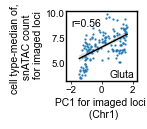

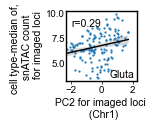

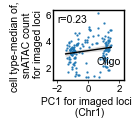

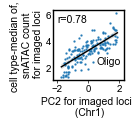

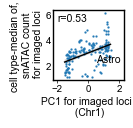

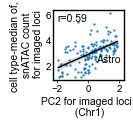

In [30]:
%matplotlib inline
chrom = 'chr1'
for cell_type in ['Gluta','Oligo','Astro','GABA','Endo'][:3]:

    rna_df = ref_measure_dict_byGroup[cell_type]
    #group_expression_chr = np.array(rna_df[rna_df.index.str.contains(f'{chrom}_')]['log10p_mean_rna'].tolist())
    group_expression_chr = np.array(rna_df[rna_df.index.str.contains(f'{chrom}_')]['mean_ATAC_2X_2000kb'].tolist())

    sel_pca_res = dict_pca_result[(cell_type, chrom)]
    for _pc_idx, group_pc1_chr in enumerate([sel_pca_res['norm_pc1'],sel_pca_res['norm_pc2']]):
        fig, ax = plt.subplots(dpi=100,figsize=(_page_width/6,_page_width/6))

        y= group_expression_chr
        x= group_pc1_chr
        plot_df = pd.DataFrame({'x':x,'y':y})
        gfg = sns.regplot(data=plot_df, x= 'x', y = 'y', ax=ax, ci=95,
                  line_kws={'linewidth':1,"color": "black"}, scatter=False,
                 )
        ax.scatter(x,y, s=0.75, 
                   #c='black',
                   alpha=0.85)

        # correlation
        X_c=x.reshape(-1, 1)
        y_c=y.reshape(-1, 1)
        reg = LinearRegression(fit_intercept=True).fit(X_c, y_c)
        y_pred = reg.predict(X_c)
        #ax.plot(X_c,y_pred,'r--',alpha=0.7,linewidth=2)

        ax.tick_params('x', labelsize=_font_size-0.5, 
                                    width=_ticklabel_width, length=_ticklabel_size,
                                    pad=1, labelbottom=True) # remove bottom ticklabels for _ax
        ax.tick_params('y', labelsize=_font_size-0.5, 
                                width=_ticklabel_width, length=0,
                                pad=1, labelleft=True)

        #ax.text(5000,600,f'r2 = {round(reg.score(X, y),2)}',fontsize=_font_size)
        #print(f'r2 = {round(reg.score(X_c, y_c),2)}')
        #ax.set_ylim([0,1.5])
        ax.set_xlim([-2.3,2.3])
        ax.set_xlabel(f'PC{_pc_idx+1} for imaged loci \n ({chrom.capitalize()})', fontsize=_font_size, labelpad=2)
        ax.set_ylabel(f'cell type-median of, \n snATAC count \n for imaged loci', fontsize=_font_size, labelpad=2)
        res = stats.spearmanr(x,y)
        #ax.set_title(f"{chrom} in {cell_type}", fontsize=_font_size,pad=5)
        ax.text(0.5,ax.get_ylim()[1]*0.35,f'{cell_type}',fontsize=_font_size)
        
        
        y_anno = ax.get_ylim()[1]*0.85
        var_exp = round(sel_pca_res['pca_explained_variance_ratio'][_pc_idx],2)
        ax.text(-2,y_anno,f'r={round(res[0],2)}',fontsize=_font_size)
        
        plt.savefig(os.path.join(output_figure_folder,f'{cell_type}_{chrom}_PC{_pc_idx+1}_corr_snATAC.pdf'),
                    transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)